# merge_data.ipynb

This file is responsible for taking all of the separate game csvs and putting them into one so we can have one trained model

After thinking on this some more it actually might make more sense to have a separate model for each game ... Still thinking this through though. Might depend on how computationally expensive it is to quickly train a model with one game's data and then make a prediction. One model could be better though if the game we are predicting has limited data and training one model off of only that data may not be sufficient.

In [19]:
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

folder = "data/CombinedPricePlayerCountHistory"
game_dfs = []

for filename in os.listdir(folder):
    if filename == "readme.md":
        continue

    # Construct filenames
    fullpath = os.path.join(folder, filename)
    appId, garbage_collector = os.path.splitext(filename)

    # Create data frame for each csv
    df = pd.read_csv(fullpath)
    df['Game_ID'] = appId
    # Put Game_ID first for visual pleasure
    cols = ['Game_ID'] + [col for col in df if col != 'Game_ID']
    df = df[cols]
    game_dfs.append(df)

# Combine them into one csv we can use to train
combined_df = pd.concat(game_dfs, ignore_index=True)

print(combined_df)

       Game_ID        Date  Playercount  Initialprice  Finalprice  Discount
0       614570  2019-04-07          103         29.99       29.99         0
1       614570  2019-04-08           71         29.99       29.99         0
2       614570  2019-04-09           67         29.99       29.99         0
3       614570  2019-04-10           58         29.99       29.99         0
4       614570  2019-04-11           55         29.99       29.99         0
...        ...         ...          ...           ...         ...       ...
597477  228280  2020-08-08          622         19.99       19.99         0
597478  228280  2020-08-09          688         19.99       19.99         0
597479  228280  2020-08-10          558         19.99       19.99         0
597480  228280  2020-08-11          529         19.99       19.99         0
597481  228280  2020-08-12          520         19.99       19.99         0

[597482 rows x 6 columns]


Now we will run this data frame through the decision tree classifier to make sure it is still able to make predictions off of it.

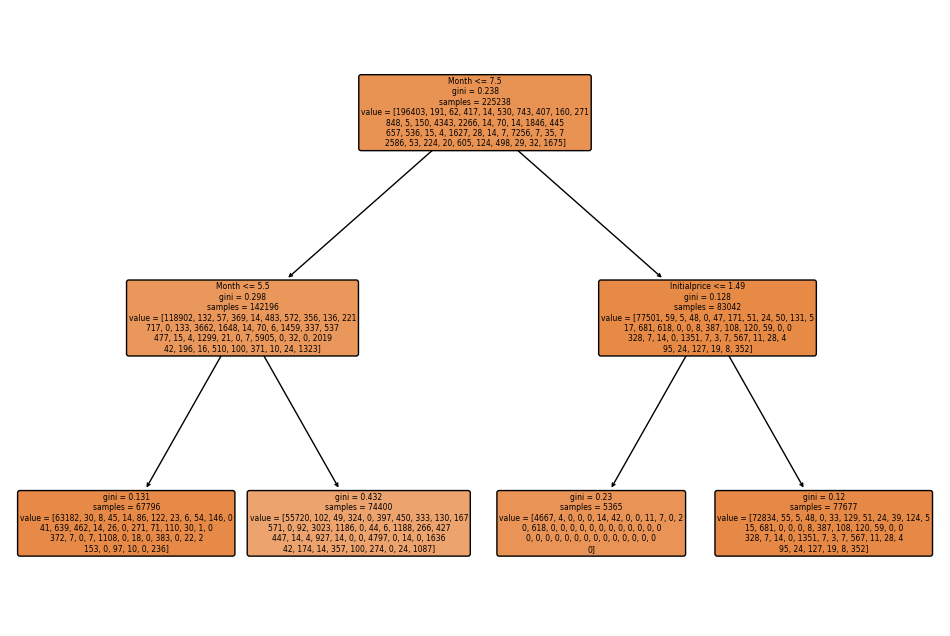

Accuracy: 0.8227936514759137


In [33]:
#read in csv, convert date column to datetime object
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

#2/3 samples train/test split
samples = len(combined_df)
split = math.floor(samples * (2/3))

#split at date 2/3 of the way through entry by using "split" to index into the df, get the date, and use that
split_date = combined_df.iloc[split]['Date']
split_date = pd.to_datetime(split_date)
train_data = combined_df[combined_df['Date'] < split_date]
test_data = combined_df[combined_df['Date'] >= split_date]

#Considering 'Finalprice' spoils whether or not there is a discount/it's amount so we omit that feature
#Set up training data
#X_train = train_data[['Date', 'Playercount', 'Initialprice','Finalprice']]
X_train = train_data[['Date', 'Playercount', 'Initialprice']]
y_train = train_data['Discount']

#Set up testing data
#X_test = test_data[['Date', 'Playercount', 'Initialprice','Finalprice']]
X_test = test_data[['Date', 'Playercount', 'Initialprice']]
y_test = test_data['Discount']

#convert dates into something more compatible with our model (dates are not ML friendly)
X_train['DayOfWeek'] = X_train['Date'].dt.dayofweek
X_train['Month'] = X_train['Date'].dt.month
X_train['Year'] = X_train['Date'].dt.year
X_test['DayOfWeek'] = X_test['Date'].dt.dayofweek
X_test['Month'] = X_test['Date'].dt.month
X_test['Year'] = X_test['Date'].dt.year

#drop the old date
X_train = X_train.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

#fit classifier to training data
model = DecisionTreeClassifier(max_depth=2)
model.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(model, filled=True, feature_names=X_train.columns.to_list(), rounded=True)
plt.show()

#make predictions on the test set
predictions = model.predict(X_test)

#evaluate/print the accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy:',accuracy)

When the model is actually making predictions, it will not know player counts for days that have not happened yet, so we will drop this from the testing set and see if it can still make predictions

In [36]:
# X_test = X_test.drop('Playercount', axis=1)

# #make predictions on the test set
# predictions = model.predict(X_test)

# #evaluate/print the accuracy
# accuracy = accuracy_score(y_test, predictions)
# print('Accuracy:',accuracy)

So if you uncomment that code you'll see that you cannot make a prediction on testing data that is not the same as testing data. We'll have to come up with another way of formatting the data.

One thing we could do is for each game, take all the dates that it has gone on sale except for the most recent one. We can combine those into some kind of feature and then make the most recent sale date be the feature. Our model could then just try and predict that day as the next sale. 